Learn iterator for thermal problems using MFEANet

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.nn.modules.utils import _pair
import os
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import time

from utils import plot
from feanet.singlegrid import SingleGrid
from feanet.multigrid import MultiGrid
from feanet.iterator import PsiNet
from feanet.iterator import PsiIterator
from data.dataset import MechanicalDataSet

Create plots for convergence test

In [2]:
N = [2**1+1, 2**2+1, 2**3+1, 2**4+1, 2**5+1, 2**6+1, 2**7+1, 2**8+1, 2**9+1]
q_v11 = [0.11111110105447959, 0.20320289267157887, 0.22705374241213908, 0.23623111562228755, 
         0.2521629576411248, 0.25900978515692, 0.26230444531364716, 0.26295500430251095, 0.26316125814795244]
q_jac = [0.33333329777930615, 0.7357023129437866, 0.9258110664371474, 0.9809080721911905, 0.9809080721911905, 
         0.9987957479351752, 0.9996457255615815, 0.9996247757202597, 0.9996247757202597]

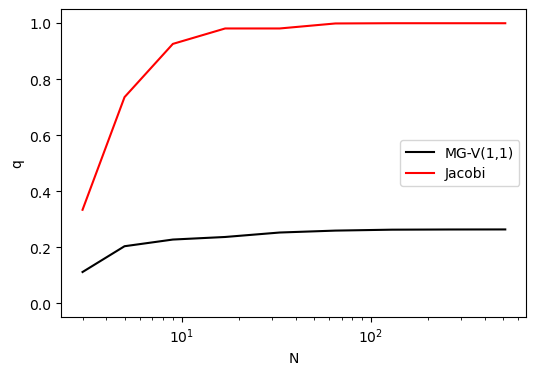

In [3]:
plt.figure(figsize=(6, 4))
plt.plot(N, q_v11, label='MG-V(1,1)', c='k')
plt.plot(N, q_jac, label='Jacobi', c='r')
plt.xscale('log')
#plt.yscale('log')
plt.xlabel('N')
plt.ylabel('q')
plt.legend(loc='center right')
plt.ylim([-0.05, 1.05])
plt.savefig('results/q_compare.png', dpi=500, bbox_inches='tight')

In [4]:
device_predict = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #torch.device('cpu') #
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
n_elem = 2**5 # element size on the edge
nb_layers = 3
bs = 5

no_neumann_train = True # not considering Neumann bc for training
no_neumann_test = False # not considering Neumann bc for testing
train = False # True or False
model_name = 'dirich_33x33_smoother'
model_dir = 'model/learn_iterator/thermal'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)


In [6]:
training_set = MechanicalDataSet('data/data_thermal/dirich_plate_train_33x33.h5', device)
train_dataloader = DataLoader(training_set, batch_size=bs, shuffle=True)
elem_mask_train, node_mask_train, dirich_idx_train, dirich_value_train, neumann_idx_train, neumann_value_train, neumann_conn_train, material_train, f_train, u_train = next(iter(train_dataloader))

test_set = MechanicalDataSet('data/data_thermal/neumann_plate_test_33x33.h5', device)
test_dataloader = DataLoader(test_set, batch_size=bs, shuffle=True)
elem_mask_test, node_mask_test, dirich_idx_test, dirich_value_test, neumann_idx_test, neumann_value_test, neumann_conn_test, material_test, f_test, u_test = next(iter(test_dataloader))

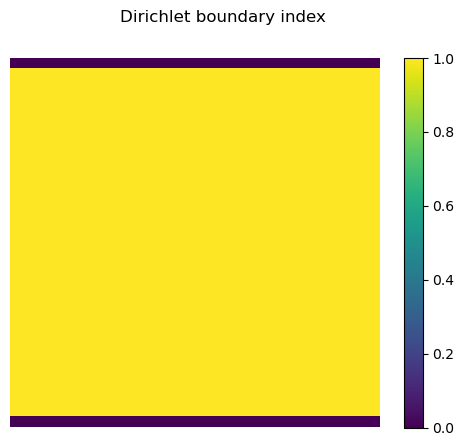

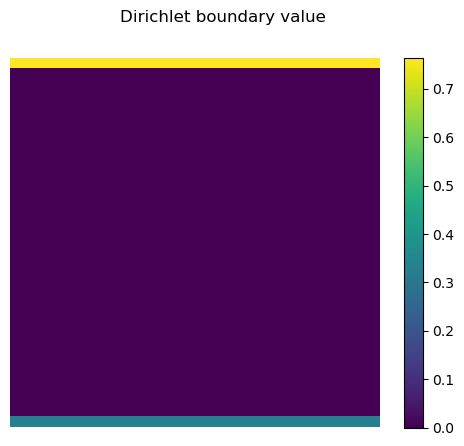

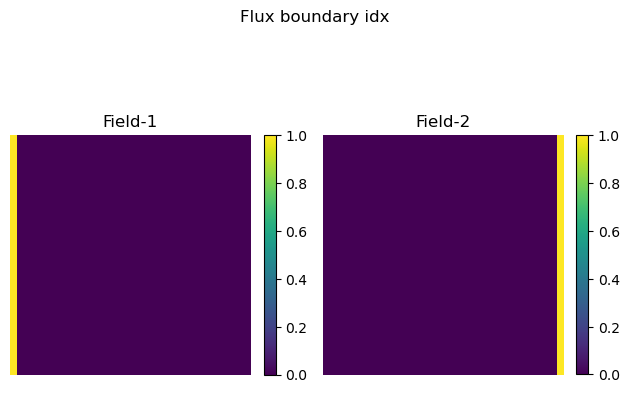

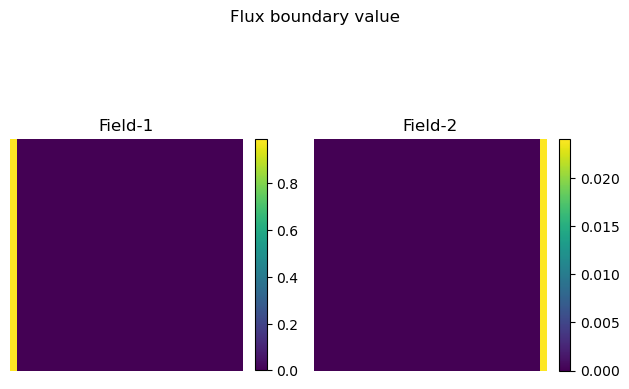

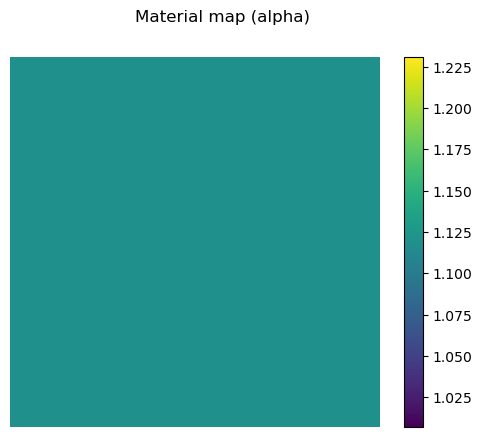

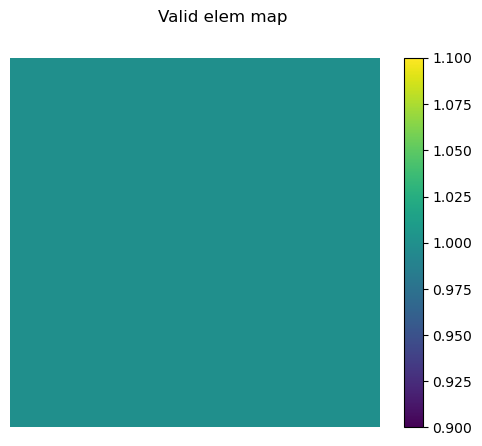

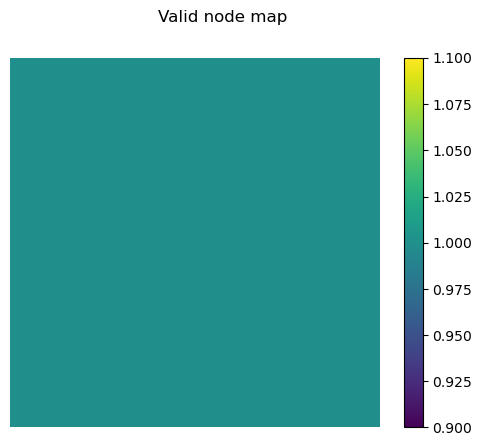

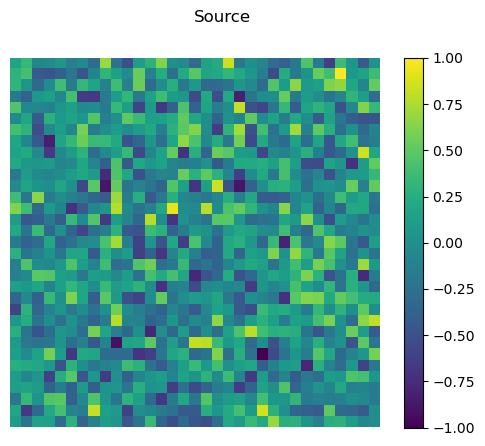

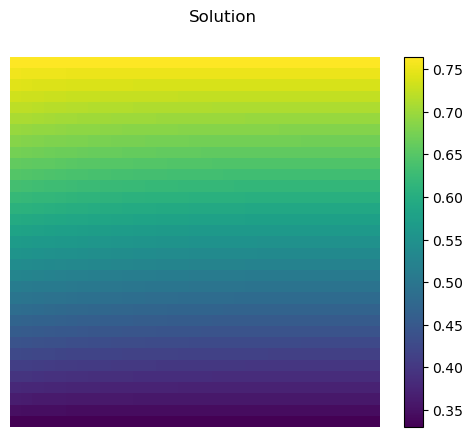

In [7]:
k = 0 # the index of test data to be shown
plot.plot_thermalfield(dirich_idx_test[k], ftitle='Dirichlet boundary index')
plot.plot_thermalfield(dirich_value_test[k], ftitle='Dirichlet boundary value')
plot.plot_elasticfield(neumann_idx_test[k], ftitle='Flux boundary idx')
plot.plot_elasticfield(neumann_value_test[k], ftitle='Flux boundary value')
plot.plot_thermalfield(material_test[k], ftitle='Material map (alpha)')
plot.plot_thermalfield(elem_mask_test[k], ftitle='Valid elem map')
plot.plot_thermalfield(node_mask_test[k], ftitle='Valid node map')
plot.plot_thermalfield(f_test[k], ftitle='Source')
plot.plot_thermalfield(u_test[k], ftitle='Solution')

Create a set of solution data for testing purpose

In [8]:
solution_test, rhs_test, d_test, d_idx_test, t_idx_test, t_test, t_conn_test, m_test, emsk_test, nmsk_test = (torch.unsqueeze(u_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(f_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(dirich_value_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(dirich_idx_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(neumann_idx_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(neumann_value_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(neumann_conn_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(material_test[k], 0).to(device_predict),
                                                                         torch.unsqueeze(elem_mask_test[k], 0).to(device_predict),
                                                                         torch.unsqueeze(node_mask_test[k], 0).to(device_predict))

Test using single grid FEA-Net

In [9]:
hsize = 2e-3 # m
ku, kf = 1, 1
grid = SingleGrid(hsize, n_elem=n_elem, mode='thermal', dev=device_predict, no_neumann=no_neumann_test)

0 4.461177893584139
1 2.4936297885558965
2 1.8066334101141723
3 1.443354207278698
4 1.2146484497559853
5 1.0557929927822063
6 0.9382218368785656
7 0.8472453257823582
8 0.7744877183826108
9 0.7148019852567873
10 0.664839804934904
11 0.622323038258042
12 0.5856444037745685
13 0.5536354195625336
14 0.525424935303868
15 0.5003493736092928
16 0.47789381625283717
17 0.4576521926343312
18 0.43929968698981847
19 0.4225731847233994
20 0.40725714071433816
21 0.3931731857623547
22 0.3801723613781161
23 0.3681292355212014
24 0.3569373860751722
25 0.34650589340589516
26 0.3367565873156753
27 0.32762186486588535
28 0.3190429450259093
29 0.3109684610243111
30 0.3033533162519709
31 0.29615774765370756
32 0.28934655379805374
33 0.2828884546330875
34 0.2767555572849247
35 0.27092290780917383
36 0.26536811304080776
37 0.26007101994501813
38 0.25501344239628965
39 0.2501789272841701
40 0.2455525533937811
41 0.241120757734769
42 0.23687118496742174
43 0.23279255635443782
44 0.228874555293498
45 0.225107726

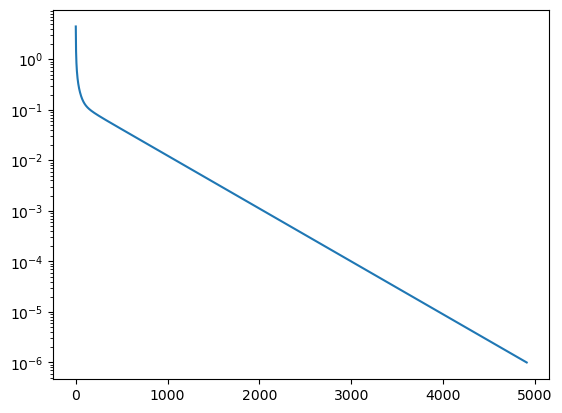

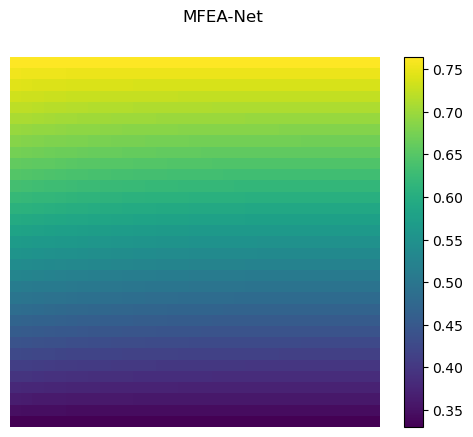

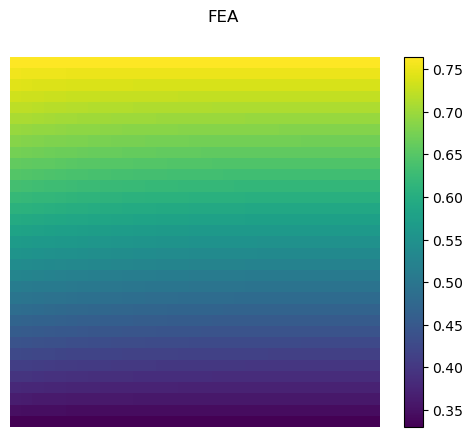

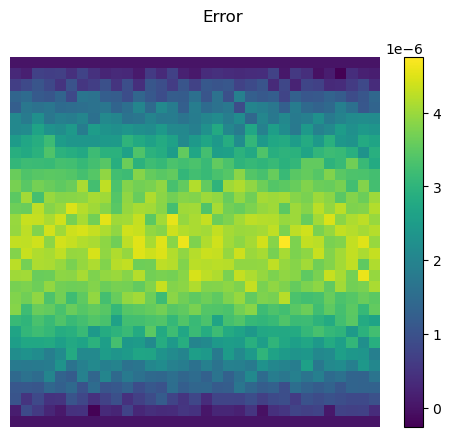

In [10]:
EPS = 1e-6
n_jac = 0
jacu_test = torch.ones(size=(1, ku, n_elem+1, n_elem+1), requires_grad=False, dtype=torch.double).to(device_predict)
jacu_test = grid.jac.reset_boundary(jacu_test, d_test, d_idx_test)
residual = grid.net(None, None, hsize, jacu_test, d_idx_test, rhs_test, t_test, t_conn_test, m_test, nmsk_test)
res = torch.norm(residual).item() 
res_arr = [res]

if(True):
    print(n_jac, res)
    while (abs(res) > EPS):
        jacu_test = grid.jac.jacobi_convolution(jacu_test, m_test, nmsk_test, d_test, d_idx_test, None, None, hsize, rhs_test, t_test, t_conn_test)
        residual = grid.net(None, None, hsize, jacu_test, d_idx_test, rhs_test, t_test, t_conn_test, m_test, nmsk_test)
        res = torch.norm(residual).item() 
        res_arr.append(res)
        n_jac += 1
        print(n_jac, res)

    print("Solution converges after", n_jac, "Jacobi iterations ")
    plt.plot(res_arr)
    plt.yscale('log')
    plt.show()

    plot.plot_thermalfield(jacu_test[0], "MFEA-Net")
    plot.plot_thermalfield(solution_test[0], "FEA")
    plot.plot_thermalfield(jacu_test[0]-solution_test[0], 'Error')

In [11]:
max_epochs = 1000

if(train):
    my_iterator = PsiIterator(device, hsize, n_elem, no_neumann_train, batch_size=bs, mode='thermal', iterator='psi', nb_layers=nb_layers, max_epochs=max_epochs)
    loss_train = torch.zeros((max_epochs, 1))
    loss_train = my_iterator.Train(training_set, model_name, model_dir)

    plt.plot(loss_train)
    plt.ylabel('loss')
    plt.yscale('log')
    plt.xlabel('epoch')
    print("Average loss: ", torch.mean(loss_train[-100:]), ", STD: ", torch.std(loss_train[-100:]))

    # save the list
    torch.save(loss_train, os.path.join(model_dir,model_name+'.pt'))


Test the learned smoother

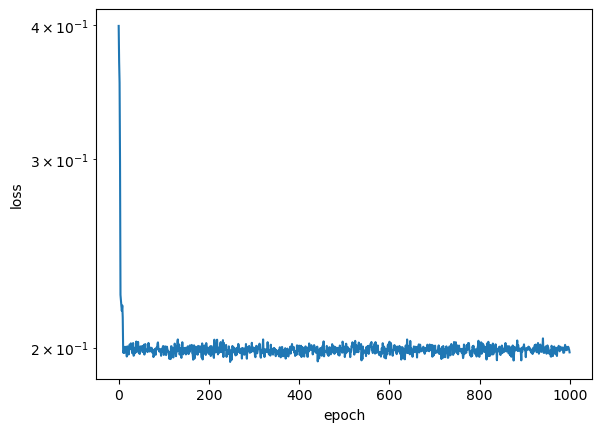

In [12]:
# import the learned model and loss train
my_net = PsiNet(nb_layers=nb_layers, mode='thermal').to(device_predict)
my_net.load_state_dict(torch.load(os.path.join(model_dir,model_name+'.pth')))
new_iterator = PsiIterator(device_predict, hsize, n_elem, no_neumann_test, psi_net=my_net, grid=grid, nb_layers=nb_layers, batch_size=1, iterator='psi')
my_loss = torch.load(os.path.join(model_dir,model_name+'.pt'))
plt.plot(my_loss)
plt.ylabel('loss')
plt.yscale('log')
plt.xlabel('epoch')
plt.savefig('results/smoother_loss.jpg', dpi=500, bbox_inches='tight')

In [13]:
list(my_net.parameters())

[Parameter containing:
 tensor([[[[-0.2123, -0.0335, -0.1305],
           [-0.4624, -1.0278, -0.0401],
           [-0.2198, -0.0409, -0.1365]]]], dtype=torch.float64,
        requires_grad=True),
 Parameter containing:
 tensor([[[[-0.1414, -0.1788, -0.2739],
           [-0.1422,  0.1062, -0.7521],
           [-0.1460, -0.1826, -0.2795]]]], dtype=torch.float64,
        requires_grad=True),
 Parameter containing:
 tensor([[[[0.1495, 0.2918, 0.1406],
           [0.5748, 0.1638, 0.0724],
           [0.1504, 0.2931, 0.1441]]]], dtype=torch.float64, requires_grad=True)]

0 4.461177893584139
1 0.9263904431977642
2 0.4491068819866254
3 0.32107301859522036
4 0.25727724638626587
5 0.21741096321847472
6 0.18986134389470768
7 0.1697540709417775
8 0.15459717153606176
9 0.14290121795057417
10 0.13368066318532443
11 0.1262485065943447
12 0.12011658116565507
13 0.11493671677524887
14 0.11046089868000214
15 0.10651264932457062
16 0.10296624954407516
17 0.09973177163965376
18 0.09674442916167875
19 0.09395708012222774
20 0.09133499135126452
21 0.08885219910544398
22 0.08648898353826916
23 0.08423011428903937
24 0.08206362738182583
25 0.07997996745600522
26 0.07797138128606582
27 0.07603148458539119
28 0.07415494885542329
29 0.07233727195236268
30 0.07057460754221224
31 0.06886363641597548
32 0.06720146792585933
33 0.0655855633924877
34 0.0640136757744819
35 0.062483801558916224
36 0.06099414197589087
37 0.05954307143219241
38 0.05812911161152862
39 0.05675091007856498
40 0.05540722250235148
41 0.0540968978163073
42 0.0528188657800986
43 0.05157212651939682
44 0.05

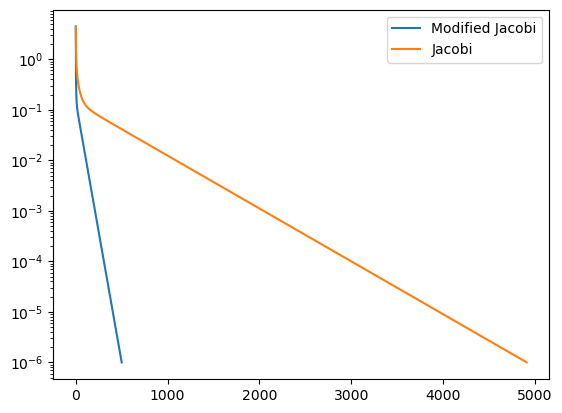

In [14]:
EPS = 1e-6
with torch.no_grad():
    n_new = 0
    u_test = torch.ones(size=(1, ku, n_elem+1, n_elem+1), requires_grad=False, dtype=torch.double).to(device_predict)
    u_test = new_iterator.grid.jac.reset_boundary(u_test, d_test, d_idx_test)
    residual = new_iterator.grid.net(None, None, hsize, u_test, d_idx_test, rhs_test, t_test, t_conn_test, m_test, nmsk_test)
    res = torch.norm(residual).item() # fix top, apply traction force at bottom boundary
    res_arr_new = [res]
    print(n_new, res)
    while (abs(res) > EPS):
        u_test = new_iterator.PsiRelax(u_test, m_test, nmsk_test, d_test, d_idx_test, None, None, hsize, rhs_test, t_test, t_conn_test, 1)
        residual = new_iterator.grid.net(None, None, hsize, u_test, d_idx_test, rhs_test, t_test, t_conn_test, m_test, nmsk_test)
        res = torch.norm(residual).item()
        res_arr_new.append(res)
        n_new += 1
        print(n_new, res)

print("Solution converges after", n_new, "iterations ")
plt.plot(res_arr_new, label='Modified Jacobi')
plt.plot(res_arr, label='Jacobi')
plt.yscale('log')
plt.legend()
plt.show()

In [15]:
def heatmap2d(arr, fname, cbar = True):
    plt.imshow(arr,cmap='viridis',vmin=-1,vmax=1)
    if(cbar is True):
        plt.colorbar()
    plt.gcf()
    plt.axis('off')
    plt.savefig(fname, dpi=500, bbox_inches='tight')
    plt.show()

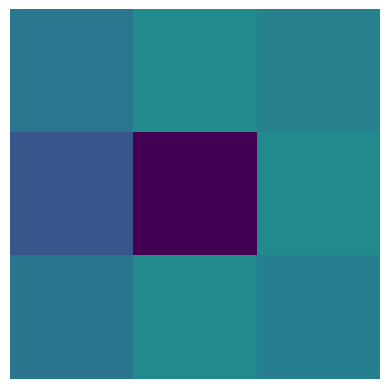

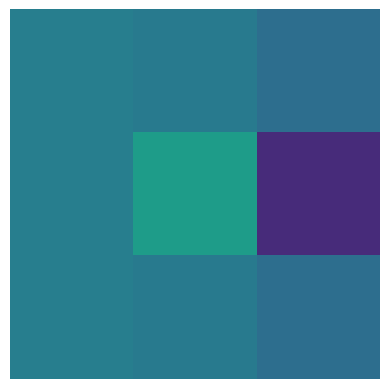

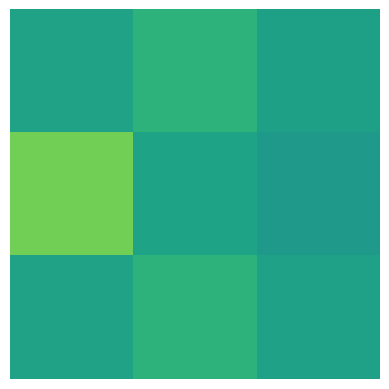

In [16]:
# plot the kernels
mlist = list(my_net.cpu().parameters())
heatmap2d(mlist[0].view(3,3).detach().numpy(),fname='results/kernel1.jpg', cbar=False)
heatmap2d(mlist[1].view(3,3).detach().numpy(),fname='results/kernel2.jpg', cbar=False)
heatmap2d(mlist[2].view(3,3).detach().numpy(),fname='results/kernel3.jpg', cbar=False)

In [17]:
def conv_op(k1, k2, max_size=7):
    '''Perform convolution operation in infinite domain'''
    size1 = k1.shape[0]
    size2 = k2.shape[0]
    
    pad1 = int((max_size-size1)/2)
    pad2 = int((max_size-size2)/2)

    k1_pad = F.pad(k1,(pad1,pad1,pad1,pad1))
    k2_pad = F.pad(k2,(pad2,pad2,pad2,pad2))
    delta = int(max_size/2)

    out_k = torch.zeros((max_size,max_size))
    for u in range(-delta, -delta+max_size):
        for v in range(-delta, -delta+max_size):
            for i in range(-delta, -delta+max_size):
                for j in range(-delta, -delta+max_size):
                    ii = u-i 
                    jj = v-j 
                    multiplier = 0.0
                    if(ii >= -delta and ii <= delta and jj >= -delta and jj <= delta):
                        multiplier = k1_pad[ii+delta,jj+delta]
                    out_k[u+delta,v+delta] += multiplier * k2_pad[i+delta,j+delta]

    return out_k

In [18]:
kernel1 = conv_op(mlist[0].view(3,3).detach(), mlist[1].view(3,3).detach(), max_size=5)
kernel2 = conv_op(kernel1, mlist[2].view(3,3).detach(), max_size=7)
kernel2 = kernel2.reshape(1,1,7,7)

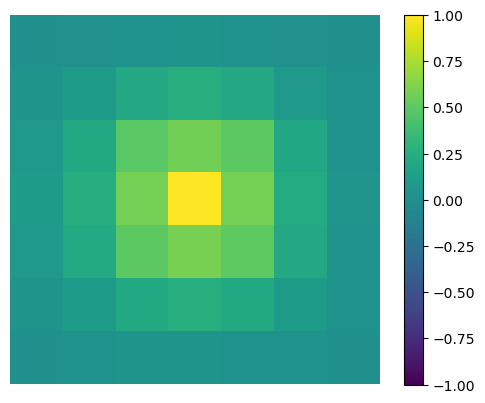

In [19]:
heatmap2d(kernel2.view(7,7).detach().numpy(),fname='results/kernel_comb.jpg')

In [20]:
with torch.no_grad():
    n = n_elem
    n_mg_jac = 0
    mg_jac = MultiGrid(hsize, n, no_neumann_test, pacnet=my_net, device=device, nb_layers=nb_layers, iterator='jac') # create a multigrid model
    mg_jac.ProblemDictArray(rhs_test,t_test,t_conn_test,d_test,d_idx_test,m_test,nmsk_test)
    u_mg_jac = torch.ones((1, 1, n+1, n+1), requires_grad=False, dtype=torch.double).to(device)
    u_mg_jac = mg_jac.iterators[0].grid.jac.reset_boundary(u_mg_jac, d_test, d_idx_test)
    residual = mg_jac.iterators[0].grid.net(None, None, hsize, u_mg_jac, d_idx_test, rhs_test, t_test, t_conn_test, m_test,nmsk_test)
    res = torch.norm(residual).item()
    err_occured = False
    res_arr_mgjac = [res]
    print(n_mg_jac, res)

    start = time.time()
    while (abs(res) > EPS):
        u_mg_jac = mg_jac.Step(u_mg_jac)
        residual = mg_jac.iterators[0].grid.net(None, None, hsize, u_mg_jac, d_idx_test, rhs_test, t_test, t_conn_test, m_test, nmsk_test)
        res = torch.norm(residual).item()
        res_arr_mgjac.append(res)
        n_mg_jac += 1
        print(n_mg_jac, res)

        if(res == torch.inf or math.isnan(res)):
            err_occured = True
            break

    end = time.time()

if(err_occured):
    print("The iteration doesn't converge!")
else:
    print("Solution converges after", n_mg_jac, "Jacobi multigrid iterations in", end-start, 'seconds.')


0 4.461177893584139
1 0.9962872033853167
2 0.24421627911761942
3 0.060450339956754764
4 0.015065741697330833
5 0.0037769531454978607
6 0.0009518658366942503
7 0.00024103576558417392
8 6.13041185009844e-05
9 1.565527543466116e-05
10 4.013071186650497e-06
11 1.0323729773315926e-06
12 2.6647168661087927e-07
Solution converges after 12 Jacobi multigrid iterations in 0.038845062255859375 seconds.


In [21]:
with torch.no_grad():
    n = n_elem
    n_mg_psi = 0
    mg_psi = MultiGrid(hsize, n, no_neumann_test, pacnet=my_net, device=device, nb_layers=nb_layers, iterator='psi') # create a multigrid model
    mg_psi.ProblemDictArray(rhs_test,t_test,t_conn_test,d_test,d_idx_test,m_test,nmsk_test)
    u_mg_psi = torch.ones((1, 1, n+1, n+1), requires_grad=False, dtype=torch.double).to(device)
    u_mg_psi = mg_psi.iterators[0].grid.jac.reset_boundary(u_mg_psi, d_test, d_idx_test)
    residual = mg_psi.iterators[0].grid.net(None, None, hsize, u_mg_psi, d_idx_test, rhs_test, t_test, t_conn_test, m_test, nmsk_test)
    res = torch.norm(residual).item()
    err_occured = False
    res_arr_mgpsi = [res]
    print(n_mg_psi, res)

    start = time.time()
    while (abs(res) > EPS):
        u_mg_psi = mg_psi.Step(u_mg_psi)
        residual = mg_psi.iterators[0].grid.net(None, None, hsize, u_mg_psi, d_idx_test, rhs_test, t_test, t_conn_test, m_test, nmsk_test)
        res = torch.norm(residual).item()
        res_arr_mgpsi.append(res)
        n_mg_psi += 1
        print(n_mg_psi, res)

        if(res == torch.inf or math.isnan(res)):
            err_occured = True
            break

    end = time.time()

if(err_occured):
    print("The iteration doesn't converge!")
else:
    print("Solution converges after", n_mg_psi, "Psi-Jacobi multigrid iterations in", end-start, 'seconds.')


0 4.461177893584139
1 0.08837800975789196
2 0.005090789681491795
3 0.0004391644378983329
4 4.208571977489572e-05
5 4.124157084421235e-06
6 4.0907255552887943e-07
Solution converges after 6 Psi-Jacobi multigrid iterations in 0.027367115020751953 seconds.


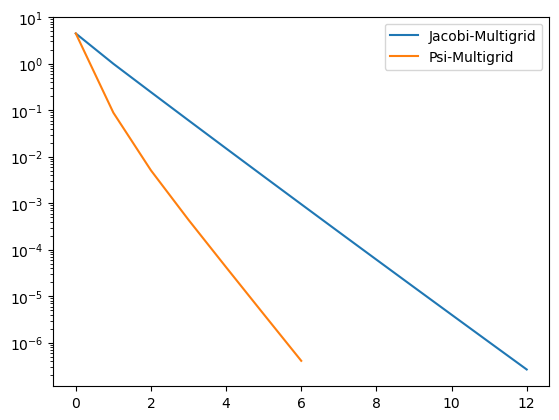

In [22]:
plt.plot(res_arr_mgjac, label='Jacobi-Multigrid')
plt.plot(res_arr_mgpsi, label='Psi-Multigrid')
plt.yscale('log')
plt.legend()
plt.show()

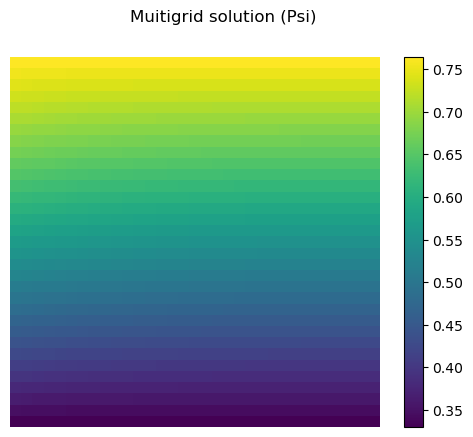

In [23]:
plot.plot_thermalfield((u_mg_psi).reshape(n+1,n+1), 'Muitigrid solution (Psi)')

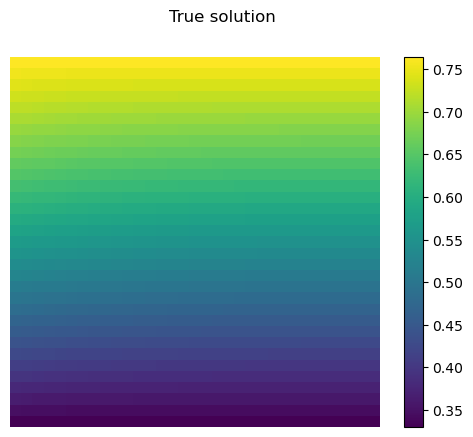

In [24]:
plot.plot_thermalfield((solution_test).reshape(n+1,n+1), 'True solution')

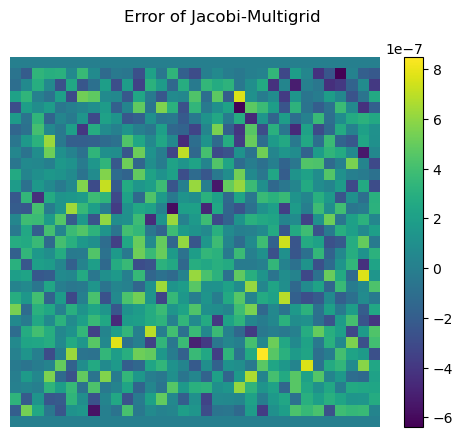

In [25]:
plot.plot_thermalfield((u_mg_jac-solution_test).reshape(n+1,n+1), 'Error of Jacobi-Multigrid')

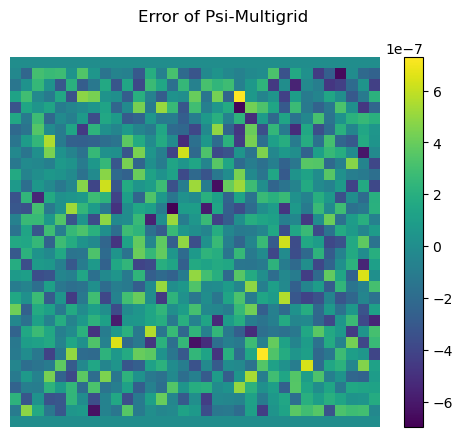

In [26]:
plot.plot_thermalfield((u_mg_psi.detach()-solution_test).reshape(n+1,n+1), 'Error of Psi-Multigrid')